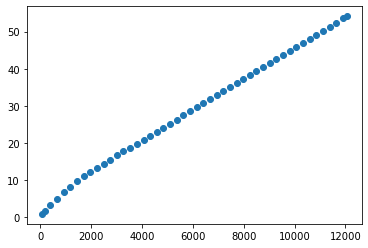

In [1]:
from typing import Callable, Dict, Tuple, Any
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
from pymc3.backends.base import MultiTrace

import matplotlib.pyplot as plt

data:pd.DataFrame = pd.read_csv('data/testdata.csv')

plt.scatter(data['time'], data[' mass gain'])
# plt.scatter(np.log(data['time']),data[' mass gain'])

def build_model(time_funtion: Callable, 
                observed_values_transformation:Callable, 
                data:pd.DataFrame = data) -> Tuple[pm.Model, np.ndarray, np.ndarray]:

    time = np.array(data['time'].values)
    time = time_funtion(time)

    mass_gain = np.array(data[' mass gain'].values)
    mass_gain = observed_values_transformation(mass_gain)
    
    with pm.Model() as model:

        nu = pm.HalfNormal('Nu', sigma=1)

        k = pm.Normal('k', mu=0, sigma = 10)
        C = pm.HalfCauchy('C', beta = 8)
        
        noise = pm.HalfCauchy('noise',beta=5)
        mean = k*time + C
        
        likelihood = pm.StudentT('likelihood', nu=nu, mu = mean, sigma = noise, observed = mass_gain)
        
    return model, time, mass_gain

def poly_model(time:np.ndarray, n:int=1) -> np.ndarray:
    return np.power(time, 1/n)

def log_model(time:np.ndarray) -> np.ndarray:
    return np.log(time)

def inv_log_model(time:np.ndarray) -> np.ndarray:
    return 1/time

# trace = pm.sample(draws=5000, chains = 3, tune=4000, target_accept=0.8)

model_mapping: Dict[str, Tuple[Callable, Callable]] = {
    'linear_model': (lambda x: poly_model(x, n=1), lambda x: poly_model(x, n=1)),
    'cuadratic_model': (lambda x: poly_model(x, n=2),lambda x: poly_model(x, n=1)),
    'cubic_model': (lambda x: poly_model(x, n=3),lambda x: poly_model(x, n=1)),
    'cuartic_model': (lambda x: poly_model(x, n=4),lambda x: poly_model(x, n=1)),
    'log_model': (log_model, poly_model),
    'inv_log_model': (log_model, inv_log_model)
}

------------------------------
Performing Inference for: linear_model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, C, k, Nu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8819279978539872, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826754742026599, but should be close to 0.8. Try to increase the number of tuning steps.


------------------------------
Performing Inference for: cuadratic_model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, C, k, Nu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


------------------------------
Performing Inference for: cubic_model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, C, k, Nu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


------------------------------
Performing Inference for: cuartic_model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, C, k, Nu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


------------------------------
Performing Inference for: log_model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, C, k, Nu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


------------------------------
Performing Inference for: inv_log_model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, C, k, Nu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6840771395820618, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


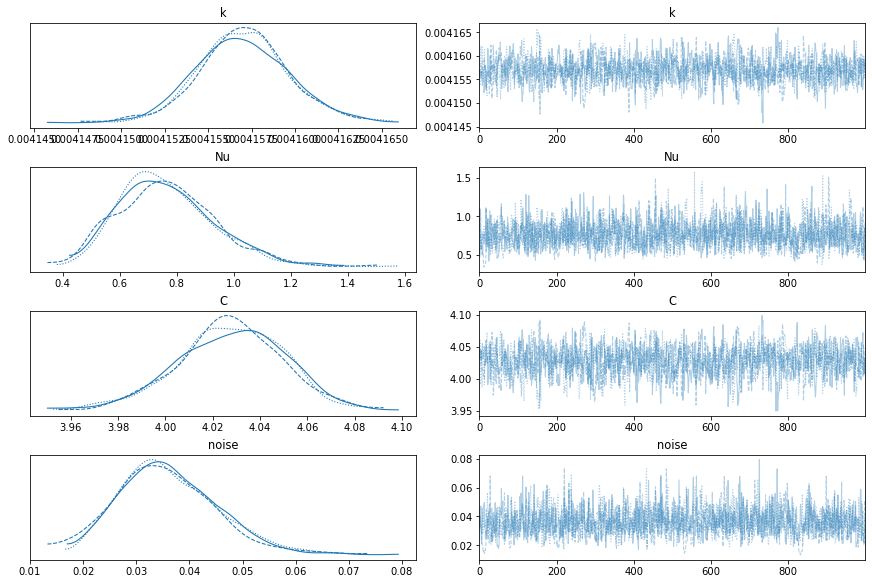

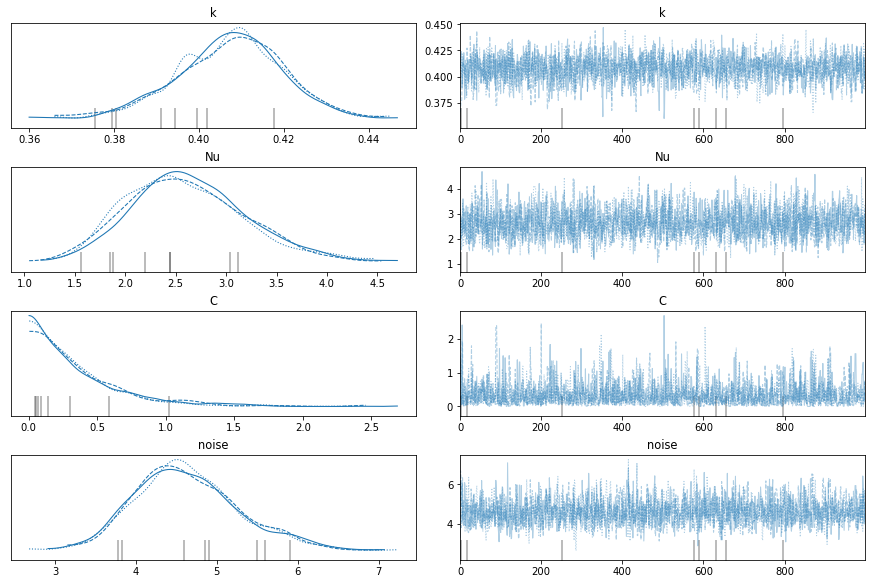

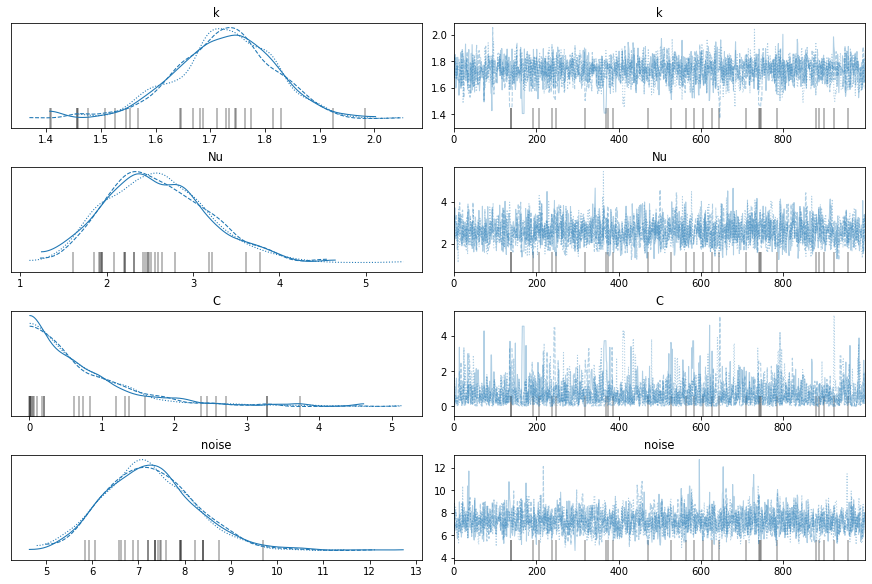

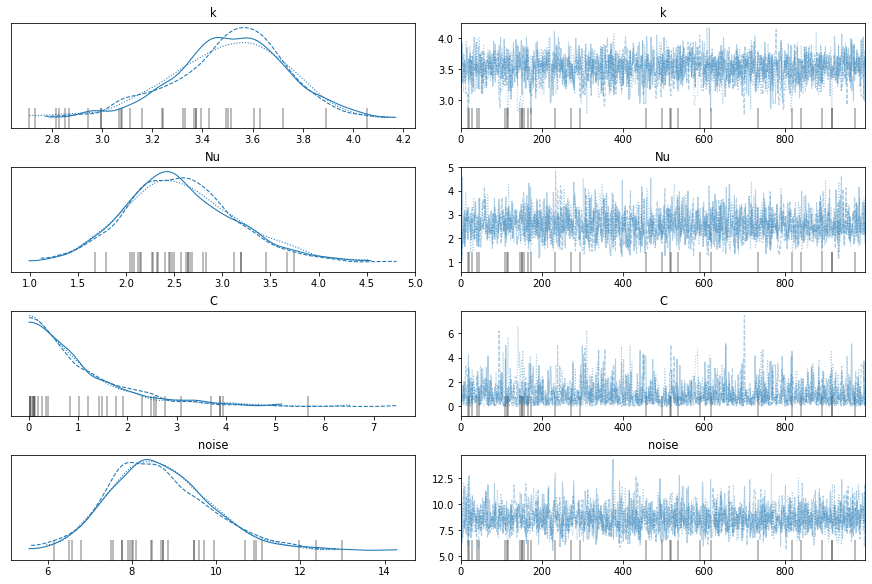

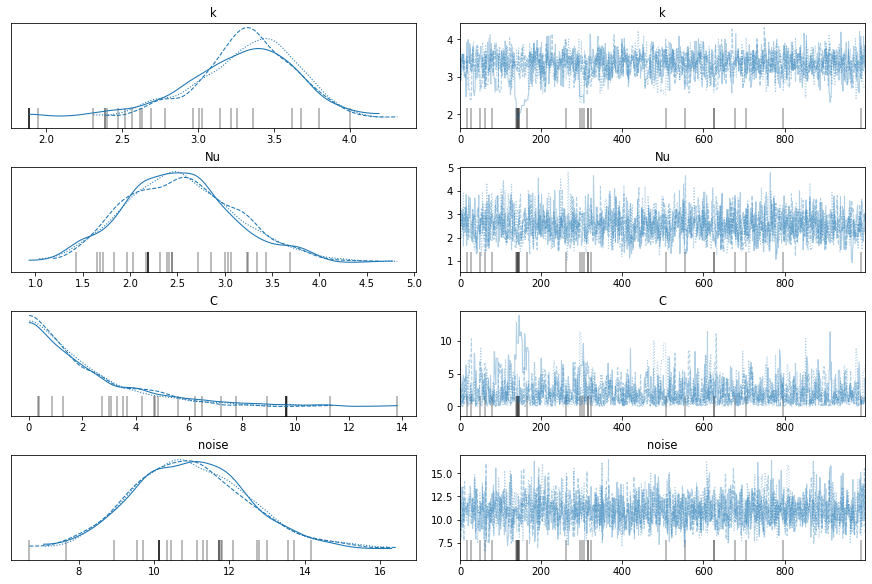

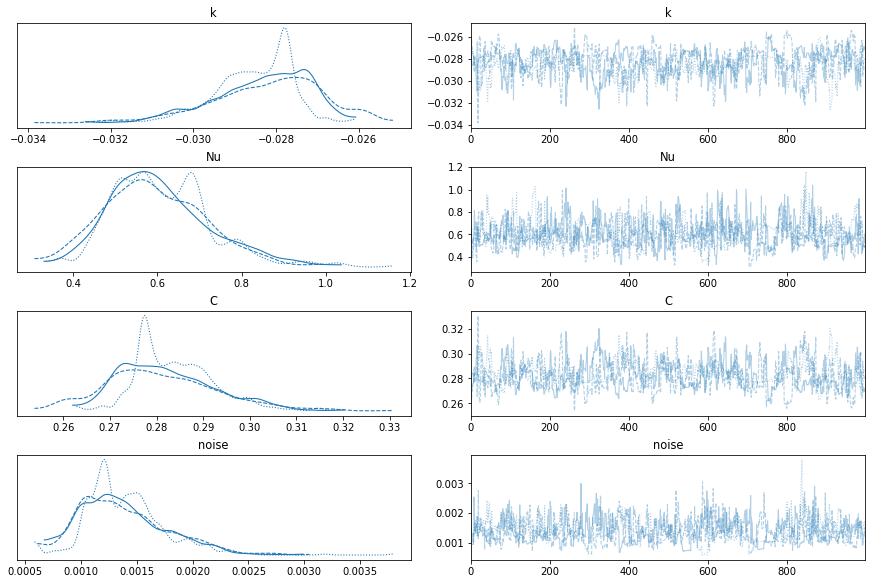

In [2]:
# Initial_inference process->
trace_dict: Dict[str, az.InferenceData] = {}

for model, args in model_mapping.items():
    print('-'*30)
    print(f'Performing Inference for: {model}')
    
    Inference_model, time, mass_gain = build_model(*args)
    
    with Inference_model:

        trace = pm.sample(return_inferencedata=True)
        trace_dict[model] = trace
        sum = az.summary(trace)
        sum.to_csv(f'summaries/{model}.csv')
        
        # print(sum)
        az.plot_trace(trace)

/home/server01/anaconda3/envs/wohler/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(
/home/server01/anaconda3/envs/wohler/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(
/home/server01/anaconda3/envs/wohler/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(
/home/server01/anaconda3/envs/wohler/lib/python3.8/site-packages

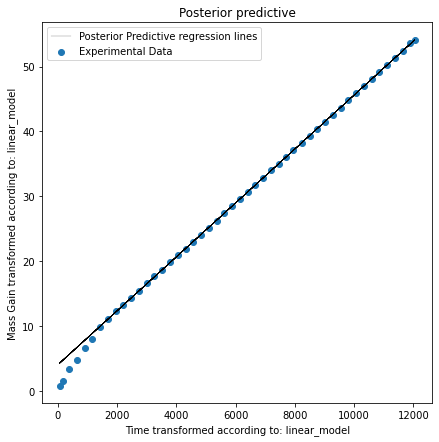

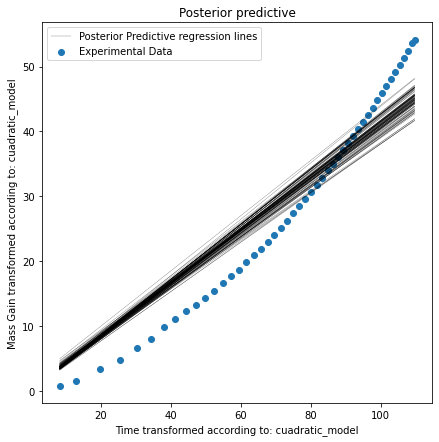

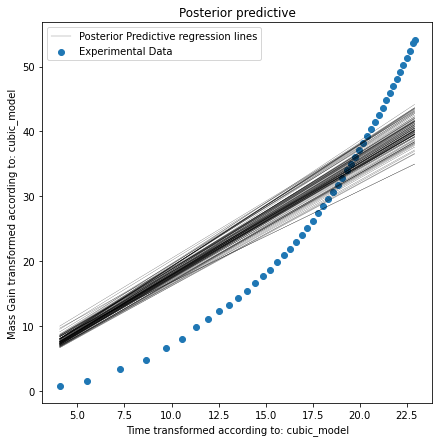

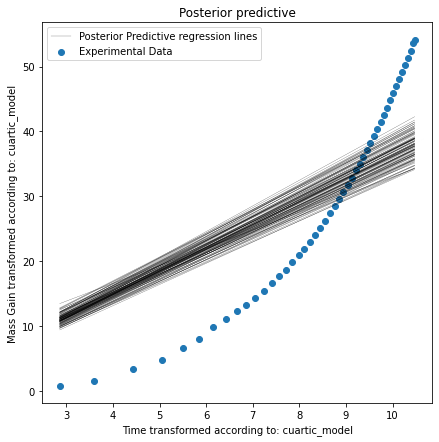

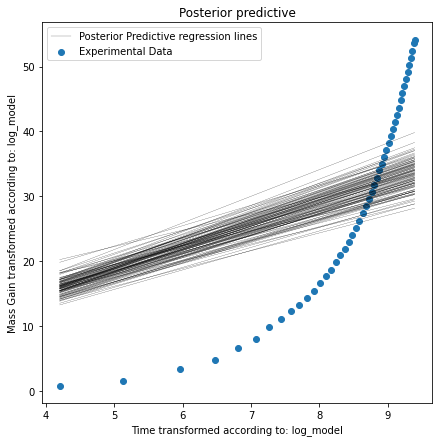

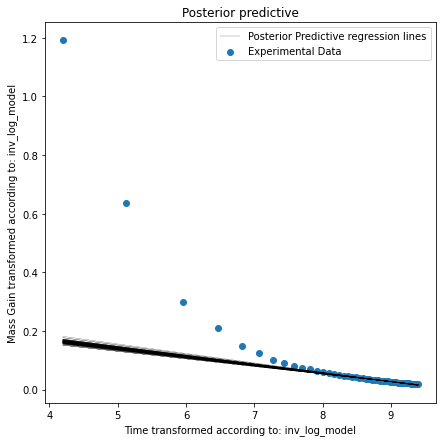

In [3]:
# Plotting the posterior ->
for model, args in model_mapping.items():
    Inference_model, time, mass_gain = build_model(*args)
    
    old_time = np.array(data['time'].values)
    
    plt.figure(figsize=(7, 7))
    plt.xlabel(f'Time transformed according to: {model}')
    plt.ylabel(f'Mass Gain transformed according to: {model}')
        
    plt.scatter(time, mass_gain, label = 'Experimental Data')
    pm.plot_posterior_predictive_glm(trace_dict[model],
                                     eval = time,
                                     lm = lambda x,sample: sample['C'] + sample['k'] * x, 
                                     samples=100, 
                                     label="Posterior Predictive regression lines")
    plt.legend()